# From Chris Chapmans "DIVAnd Create 2d Slice" - Create_BG_Temperature_Field_Synthetic.ipynb

# parameter sandbox

<font size="25"> DIVAnd Create 2d Slice</font> \n
This notebook illustrates how to use DIVAnd to create a simple map of temperature over the CARSv2 region for use as a background field.
NOTE: This is my first attempt, and optimisation hasn't been undertaken


In [ ]:
using DIVAnd
using PyPlot
using NCDatasets
using DataStructures
using Dates
using Statistics
using Polynomials

Load the data from the netcdf files. Individual observation "platforms" are found in different netcdf files, 
following WOD convention.

In [2]:
data_path  = "/tube1/cha674/CARS_2022_ancillary_data/Synthetic_WOD/2018/"
data_file_stem = "synthetic_wod_2018_"

#platform_types = ["ctd","pfl","xbt","mrb","gld","osd"]
platform_types = ["pfl"]

WOD_datasets = []

for i_platform in platform_types
    WOD_data_full_path = string(data_path,data_file_stem,i_platform,".nc")
    println(WOD_data_full_path)
    ds = Dataset(WOD_data_full_path)
    push!(WOD_datasets,ds)
end


/tube1/cha674/CARS_2022_ancillary_data/Synthetic_WOD/2018/synthetic_wod_2018_pfl.nc


Convert the raw times (in nanosecconds since) to date time format

In [3]:
start_date = WOD_datasets[1]["time"].attrib["units"][19:end]
start_date  = DateTime(start_date[1:19],dateformat"y-m-d HH:MM:SS")

time_dates = start_date + Dates.Second.(Int64.(floor.(WOD_datasets[1]["time"].var[:]*1.0e-9) ))

┌ Warning: unknown units nanoseconds
└ @ NCDatasets /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/NCDatasets/h1epE/src/cfvariable.jl:407
┌ Warning: unknown units nanoseconds
└ @ NCDatasets /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/NCDatasets/h1epE/src/cfvariable.jl:407


17324-element Vector{DateTime}:
 2018-01-01T00:59:02
 2018-01-01T00:02:48
 2018-01-01T01:15:56
 2018-01-01T01:18:45
 2018-01-01T01:32:48
 2018-01-01T02:26:15
 2018-01-01T02:57:10
 2018-01-01T03:50:37
 2018-01-01T03:28:07
 2018-01-01T03:36:31
 2018-01-01T03:42:10
 2018-01-01T04:27:10
 2018-01-01T04:07:29
 ⋮
 2018-12-31T18:56:15
 2018-12-31T18:30:56
 2018-12-31T19:46:51
 2018-12-31T20:20:37
 2018-12-31T20:59:59
 2018-12-31T21:36:31
 2018-12-31T21:39:21
 2018-12-31T22:07:29
 2018-12-31T22:01:51
 2018-12-31T22:10:18
 2018-12-31T22:04:40
 2018-12-31T23:26:15

Format and concatenate the data from the netcdf files in a form that DIVAnd can understand. 
We also remove NaN values and data that is identically equal to zero. Here is where checking the QC-flags could come in handy.

In [ ]:
longitude = []
latitude  = []
temperature = []
time =  []
depth       = []
for (platform_index, current_platform) in enumerate(platform_types)
    println(platform_index,current_platform)
    longitude   =  vcat(longitude,WOD_datasets[platform_index]["longitude"].var[:,:])
    latitude   =  vcat(latitude,WOD_datasets[platform_index]["latitude"].var[:,:])

    #latitude    = WOD_datasets[platform_index]["latitude"].var[:,:]
    temperature = vcat(temperature,WOD_datasets[platform_index]["temp"].var[1,:])
    time        = vcat(time,WOD_datasets[platform_index]["time"].var[:,:])
    
    depth       =  vcat(depth,WOD_datasets[platform_index]["depth"].var[1])

    
end
deleteat!(longitude  , findall(isnan.(temperature)) )
deleteat!(latitude   , findall(isnan.(temperature)) )
deleteat!(time       , findall(isnan.(temperature)) )
deleteat!(temperature, findall(isnan.(temperature)) )

deleteat!(longitude  , findall(temperature.==0) )
deleteat!(latitude   , findall(temperature.==0) )
deleteat!(time       , findall(temperature.==0) )
deleteat!(temperature, findall(temperature.==0) )

observation_id =[0:length(longitude):1]


Check-obs - inbuilt function to get range of observations in both geographic space and data space. Good for identifying any remaining outliers.

In [5]:
checkobs((longitude.+360.0,latitude,depth,time),temperature,observation_id)


┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /tube1/cha674/Anaconda_Install/miniconda/envs/julia/share/julia/packages/DIVAnd/MV3j9/src/obsstat.jl:77


              minimum and maximum of obs. dimension 1: (90.0059814453125, 179.94830322265625)
              minimum and maximum of obs. dimension 2: (-49.95988f0, -0.052f0)
              minimum and maximum of obs. dimension 3: (0.5412807464599609, 0.5412807464599609)
              minimum and maximum of obs. dimension 4: (-3373920283648, 31530433681690624)
                          minimum and maximum of data: (2.502504587173462, 31.455183029174805)


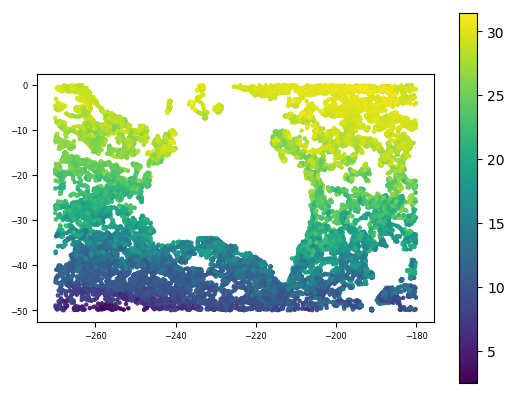

PyObject <matplotlib.colorbar.Colorbar object at 0x7fae87c7b860>

In [31]:
figure("Synth-WOD")
ax = subplot(1,1,1)
scatter(longitude, latitude, c=temperature,s=5)
aspectratio = 1/cos(mean(latitude) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
colorbar()
#colorbar(orientation="vertical")

Note that there is an obvious dependence of the temperature with latitude. We remove this dependence using a linear fit to a quadratic function. Failure to remove this latitudinal dependence results in a background field that simply reflects the north-south temperature gradient.

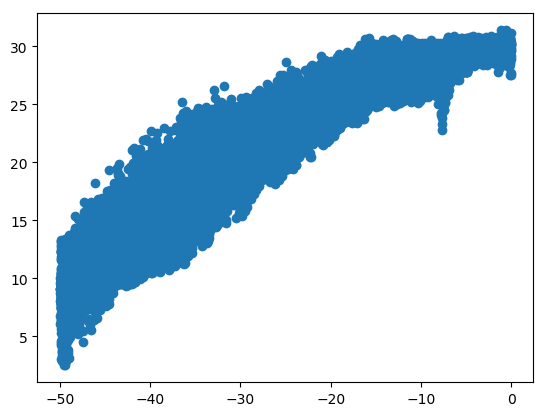

PyObject <matplotlib.collections.PathCollection object at 0x7fae87b3b160>

In [32]:
scatter(latitude,temperature)


Linear-fit to latitude achieved using the "curve_fit" package. 

In [9]:
using LsqFit
@. model(x, p) = p[1] + p[2]*x + p[3]*x*x
p0 = [0.5,0.5,0.5]
fit_temperature_to_latitude = curve_fit(model, latitude, temperature, p0)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Any}}([30.35917096485205, 0.1303178057606762, -0.006502229245747169], [-2.2762983434845907, 0.7112141088974937, 0.855053690137634, -0.49594011297469365, -3.6877775951947953, -5.680038046770903, -0.3380640708202485, 0.45274340950432723, 0.5778962625538924, 0.5562625991717347  …  1.3338292215432492, -0.9410683879963138, 1.5097894815711985, -0.8586934518651788, -0.6745469654306717, -2.621412839952473, 0.3920029146668842, 3.4541345633441853, 0.8727036051284589, -1.6194010978060618], [1.0000000000037874 -17.81500053412858 317.3742440283349; 1.0000000000037874 -15.880040168617436 252.17567576164396; … ; 1.0000000000037874 -45.01800155626476 2026.6204641317497; 1.0000000000037874 -15.963100433620173 254.8205754453273], true, Any[])

In [23]:
fit_temperature_to_latitude.param

3-element Vector{Float64}:
 30.35917096485205
  0.1303178057606762
 -0.006502229245747169

In [27]:
model(yi,fit_temperature_to_latitude.param)

181×101 Matrix{Float64}:
 7.58771  7.97635  8.36175  8.74389  …  30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389  …  30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389  …  30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592
 7.58771  7.97635  8.36175  8.74389     30.1491  30.2224  30.2924  30.3592


Plot the residuals after the the quadratic fitting exercise to check if the latitudinal temperature gradient has been removed.

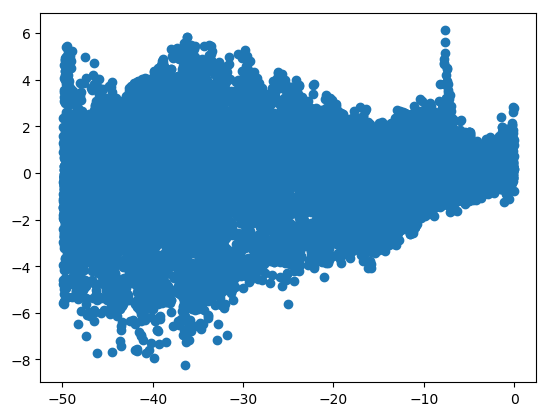

PyObject <matplotlib.collections.PathCollection object at 0x7fae9eb49390>

In [34]:
scatter(latitude,fit_temperature_to_latitude.resid)

In [11]:
temperature_residual = fit_temperature_to_latitude.resid

17271-element Vector{Float64}:
 -2.2762983434845907
  0.7112141088974937
  0.855053690137634
 -0.49594011297469365
 -3.6877775951947953
 -5.680038046770903
 -0.3380640708202485
  0.45274340950432723
  0.5778962625538924
  0.5562625991717347
 -0.2172677126787761
  2.6878326567441952
 -1.3331185590641645
  ⋮
  0.1906753874950553
 -1.3655141392343602
  1.3338292215432492
 -0.9410683879963138
  1.5097894815711985
 -0.8586934518651788
 -0.6745469654306717
 -2.621412839952473
  0.3920029146668842
  3.4541345633441853
  0.8727036051284589
 -1.6194010978060618

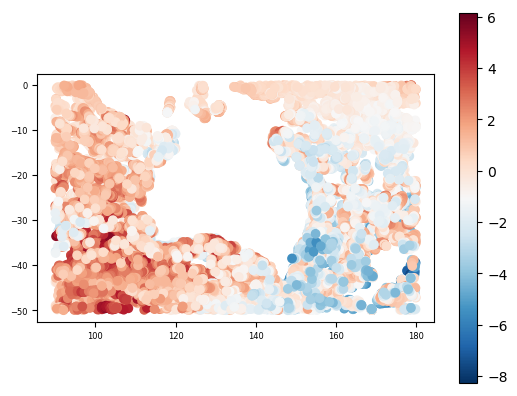

PyObject <matplotlib.colorbar.Colorbar object at 0x7fae9ea54240>

In [35]:
figure("Synth-WOD")
ax = subplot(1,1,1)
scatter(longitude.+360, latitude, c=temperature_residual,cmap="RdBu_r")
aspectratio = 1/cos(mean(latitude) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
colorbar()

Load the bathymetry for creation of the land-sea mask

bathname = "/tube1/cha674/cars-v2/notebooks/gebco_30sec_16.nc"
bathisglobal = true

dx = 0.5 # longitude resolution in degrees
dy = 0.5 # latitude resolution in degrees

lonr = 90.:dx:180.; # the range of longitudes (start:step:end)
latr = -50.:dy:0.; # the range of latitudes (start:step:end)

bx,by,b = extract_bath(bathname,true,lonr,latr)

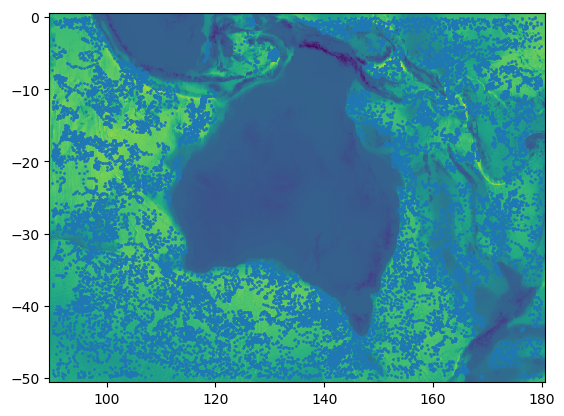

PyObject <matplotlib.collections.PathCollection object at 0x7fae9e9c3b00>

In [37]:
pcolormesh(bx,by,b')
scatter(longitude.+360, latitude,s=1)

Create the grid and grid-metric (ie. the effective distances in meters)

In [38]:
xi,yi,mask = load_mask(bathname,true,lonr,latr,0)
pm,pn = DIVAnd_metric(lonr,latr);
xi,yi = ndgrid(xi,yi)

([90.0 90.0 … 90.0 90.0; 90.5 90.5 … 90.5 90.5; … ; 179.5 179.5 … 179.5 179.5; 180.0 180.0 … 180.0 180.0], [-50.0 -49.5 … -0.5 0.0; -50.0 -49.5 … -0.5 0.0; … ; -50.0 -49.5 … -0.5 0.0; -50.0 -49.5 … -0.5 0.0])

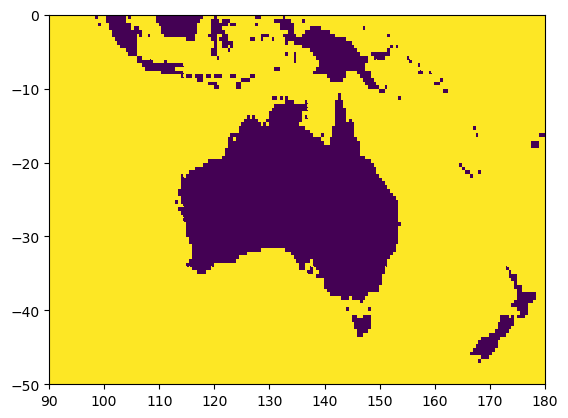

PyObject <matplotlib.collections.QuadMesh object at 0x7fae86984320>

In [39]:
pcolormesh(xi,yi,mask)

Run DIVAndrun. Correlation length scales are chosen following Chris Roach's Oxygen Atlas and have not been optimised

In [19]:
lenx = 500.0 * 1000.0
leny = 250.0 * 1000.0
lent = 5.0
epsilon = 1.0
#wu= 1.0
#temperature_anom = temperature .- mean(temperature)

fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(longitude.+360,latitude),temperature_residual,(lenx,leny),epsilon) #, moddim=md)

([0.6198240502473665 0.5654659647328931 … 0.34340552494241183 0.3676301703632523; 0.8831456279793775 0.8572468936176082 … 0.42091090714859225 0.472109714709143; … ; -1.0748166854159846 -0.867619330087075 … 1.2692810290692311 1.4268269068630752; -0.9855295661764056 -0.8640849129283252 … 1.1394401912820764 1.327128747197932], DIVAnd.DIVAnd_struct{Float64, Int64, 2, SparseArrays.SparseMatrixCSC{Float64, Int64}}(2, 2, 1.5707963330122983e12, statevector{1, 2}((Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1],), 1, [14714], [18281], [(181, 101)], [0, 14714], 14714, [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  18272, 18273, 18274, 18275, 18276, 18277, 18278, 18279, 18280, 18281]], [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714]]), sparse([1, 2, 182, 1, 2, 3, 183, 2, 3, 4  …  14711, 14712, 14713, 14560, 14712, 14713, 14714, 14561, 14713, 14714], [1, 1, 1, 2, 2, 2, 2, 3, 3, 3  …  14712, 14712, 14712, 14713, 14713, 14713, 14713, 14714, 14714, 

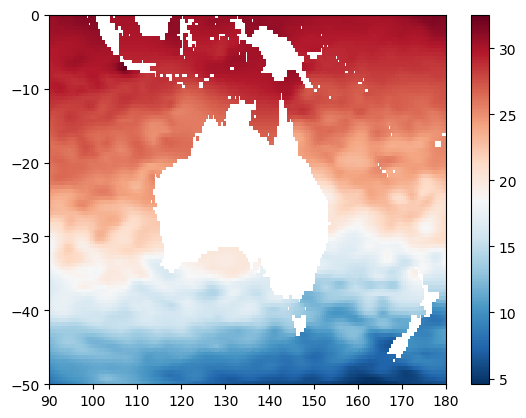

PyObject <matplotlib.colorbar.Colorbar object at 0x7fae87e95cf8>

In [29]:
pcolor(xi, yi, fi.+model(yi,fit_temperature_to_latitude.param),cmap="RdBu_r") #.+ mean(temperature) ); 
colorbar()

In [28]:
size(fi)

(181, 101)

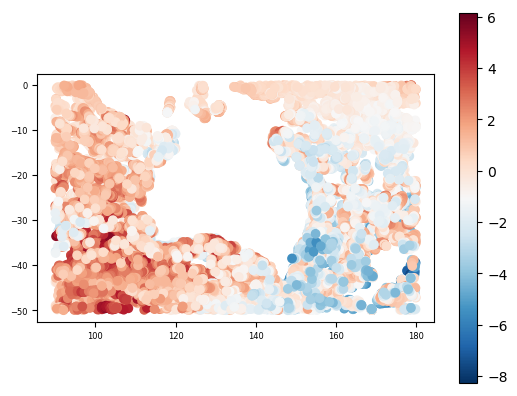

PyObject <matplotlib.colorbar.Colorbar object at 0x7fae886f1780>

In [21]:

figure("Synth-WOD")
ax = subplot(1,1,1)
scatter(longitude.+360, latitude, c=temperature_residual,cmap="RdBu_r")
aspectratio = 1/cos(mean(latitude) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
colorbar()

In [ ]:
fit_temperature_to_latitude.param